<a href="https://colab.research.google.com/github/DreamX55/FL-Models-Research-Paper-Codes/blob/main/Centralized%2BDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 Using device: cuda


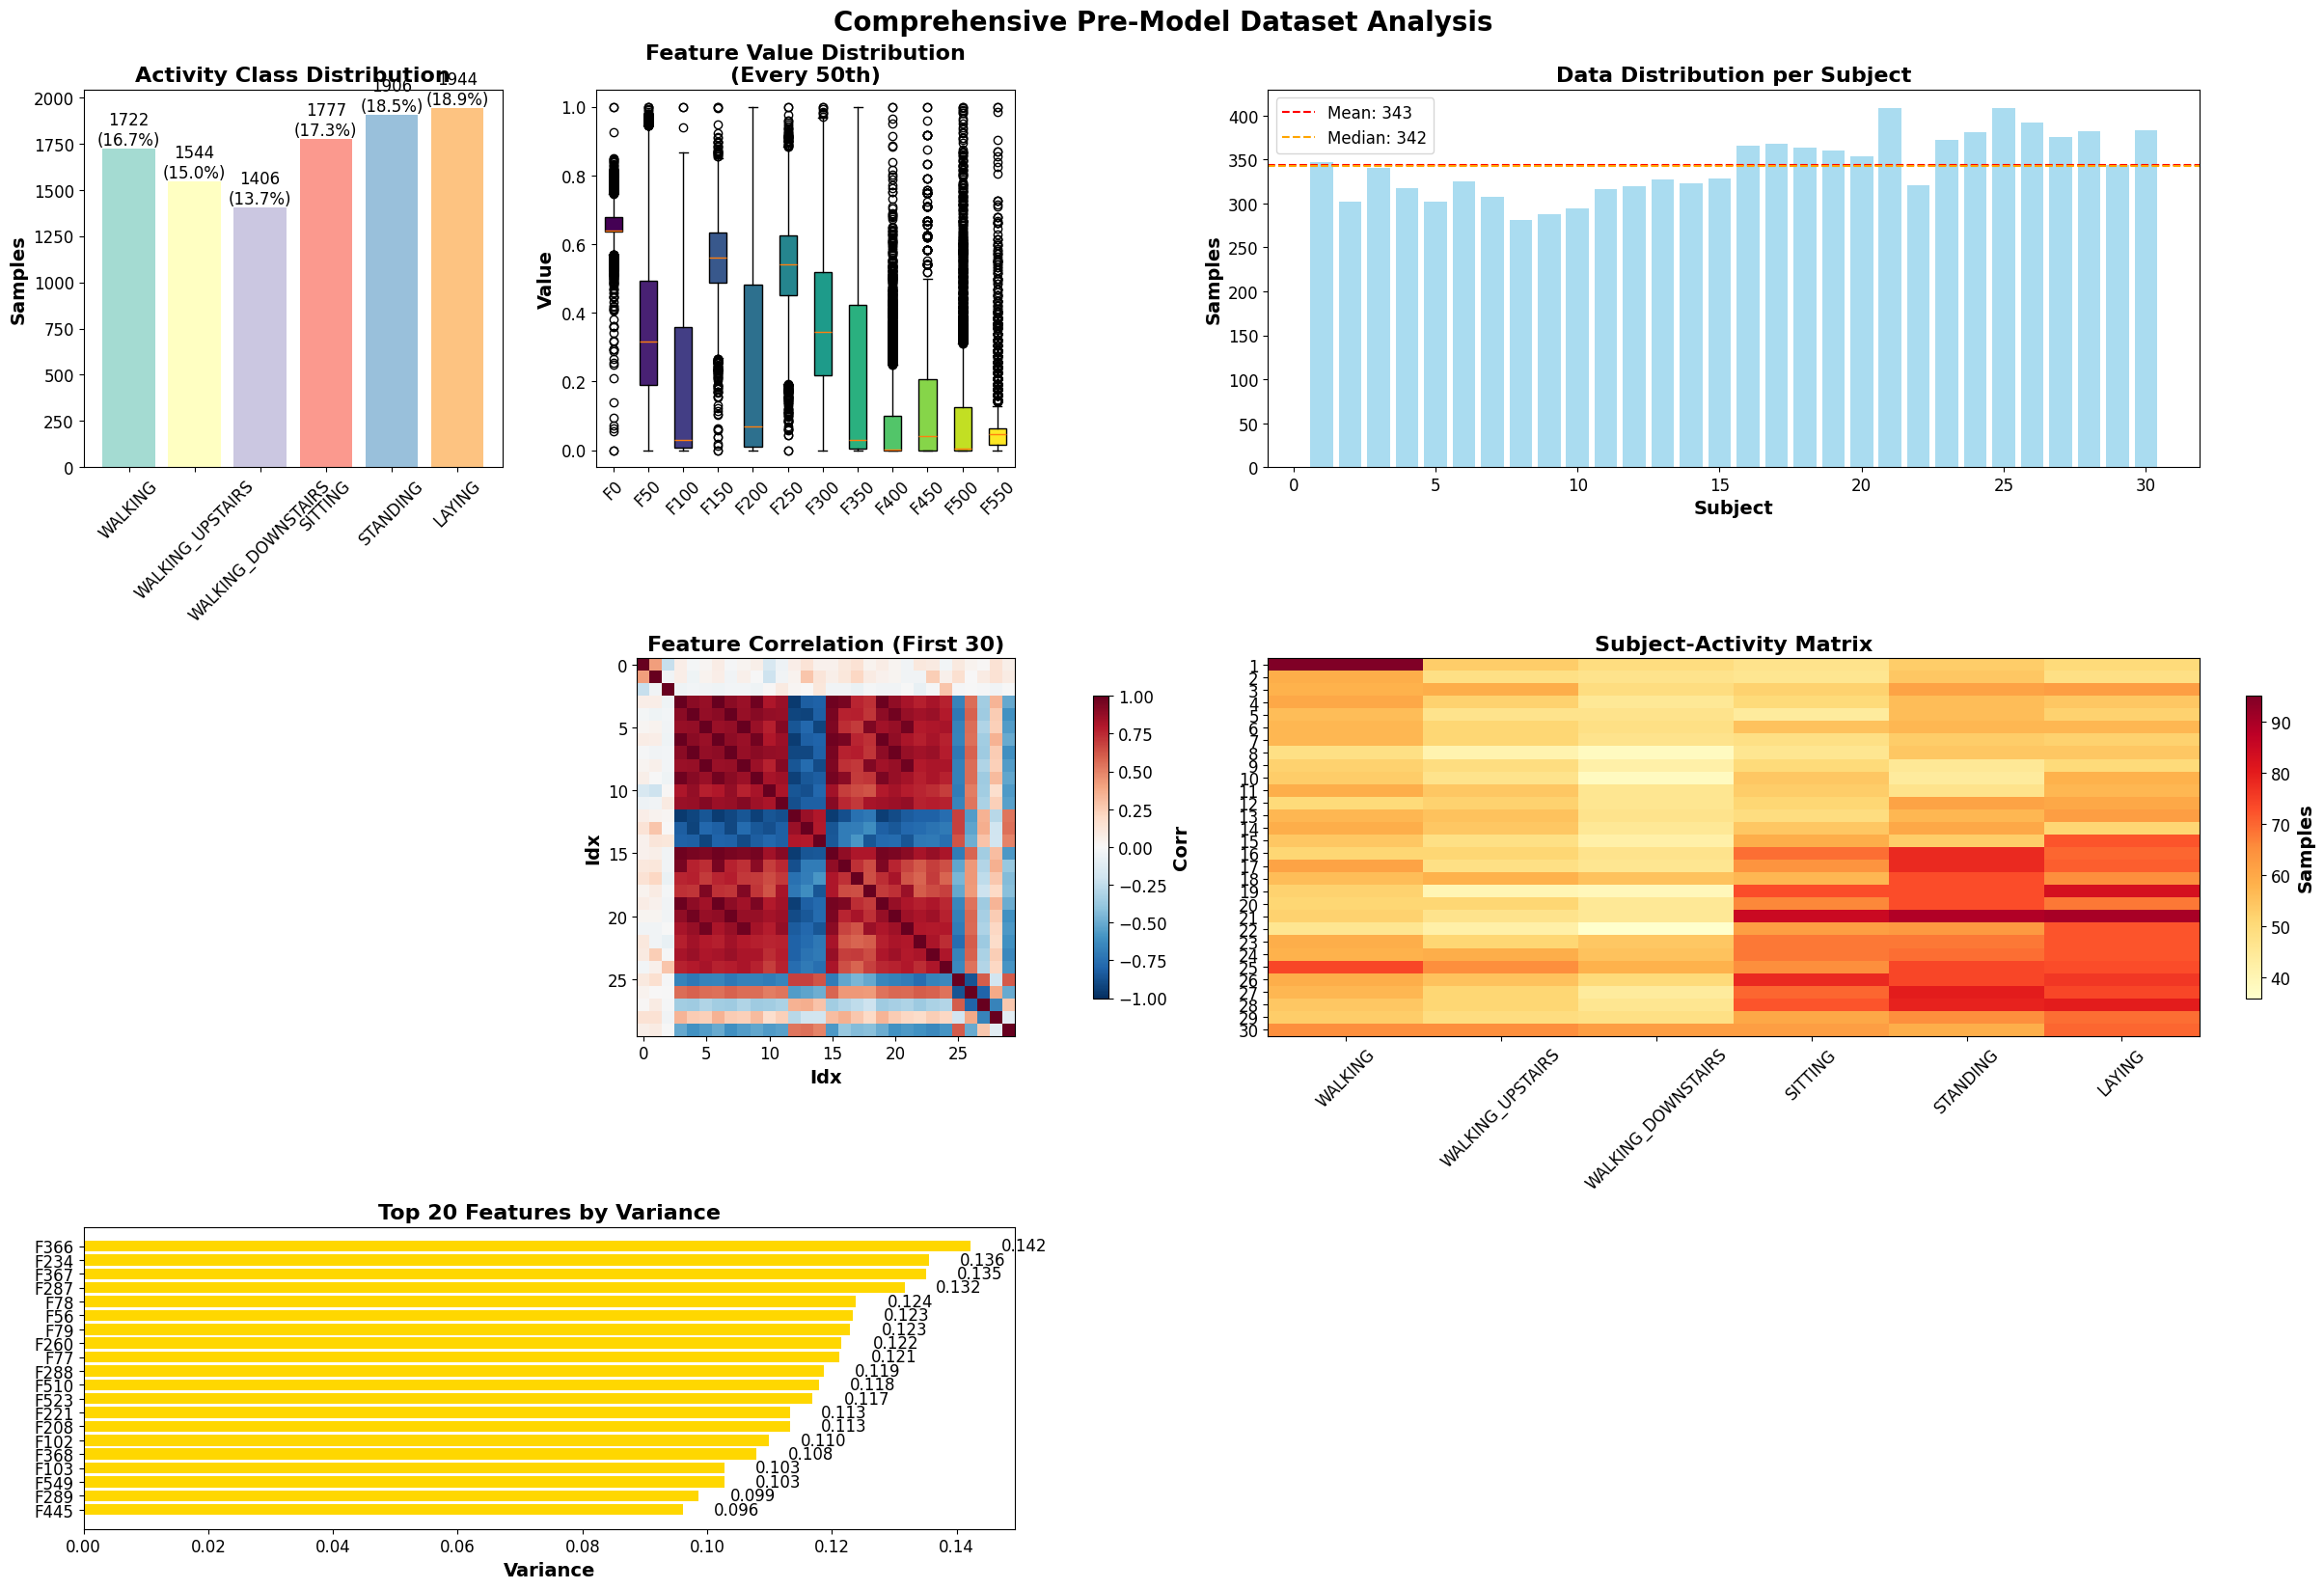


🚀 Starting Centralized Learning with DP...
Epoch 10: Acc=0.4995, F1=0.3968
Epoch 20: Acc=0.7143, F1=0.7108
Epoch 30: Acc=0.8303, F1=0.8239
Epoch 40: Acc=0.8392, F1=0.8371
Epoch 50: Acc=0.8459, F1=0.8481


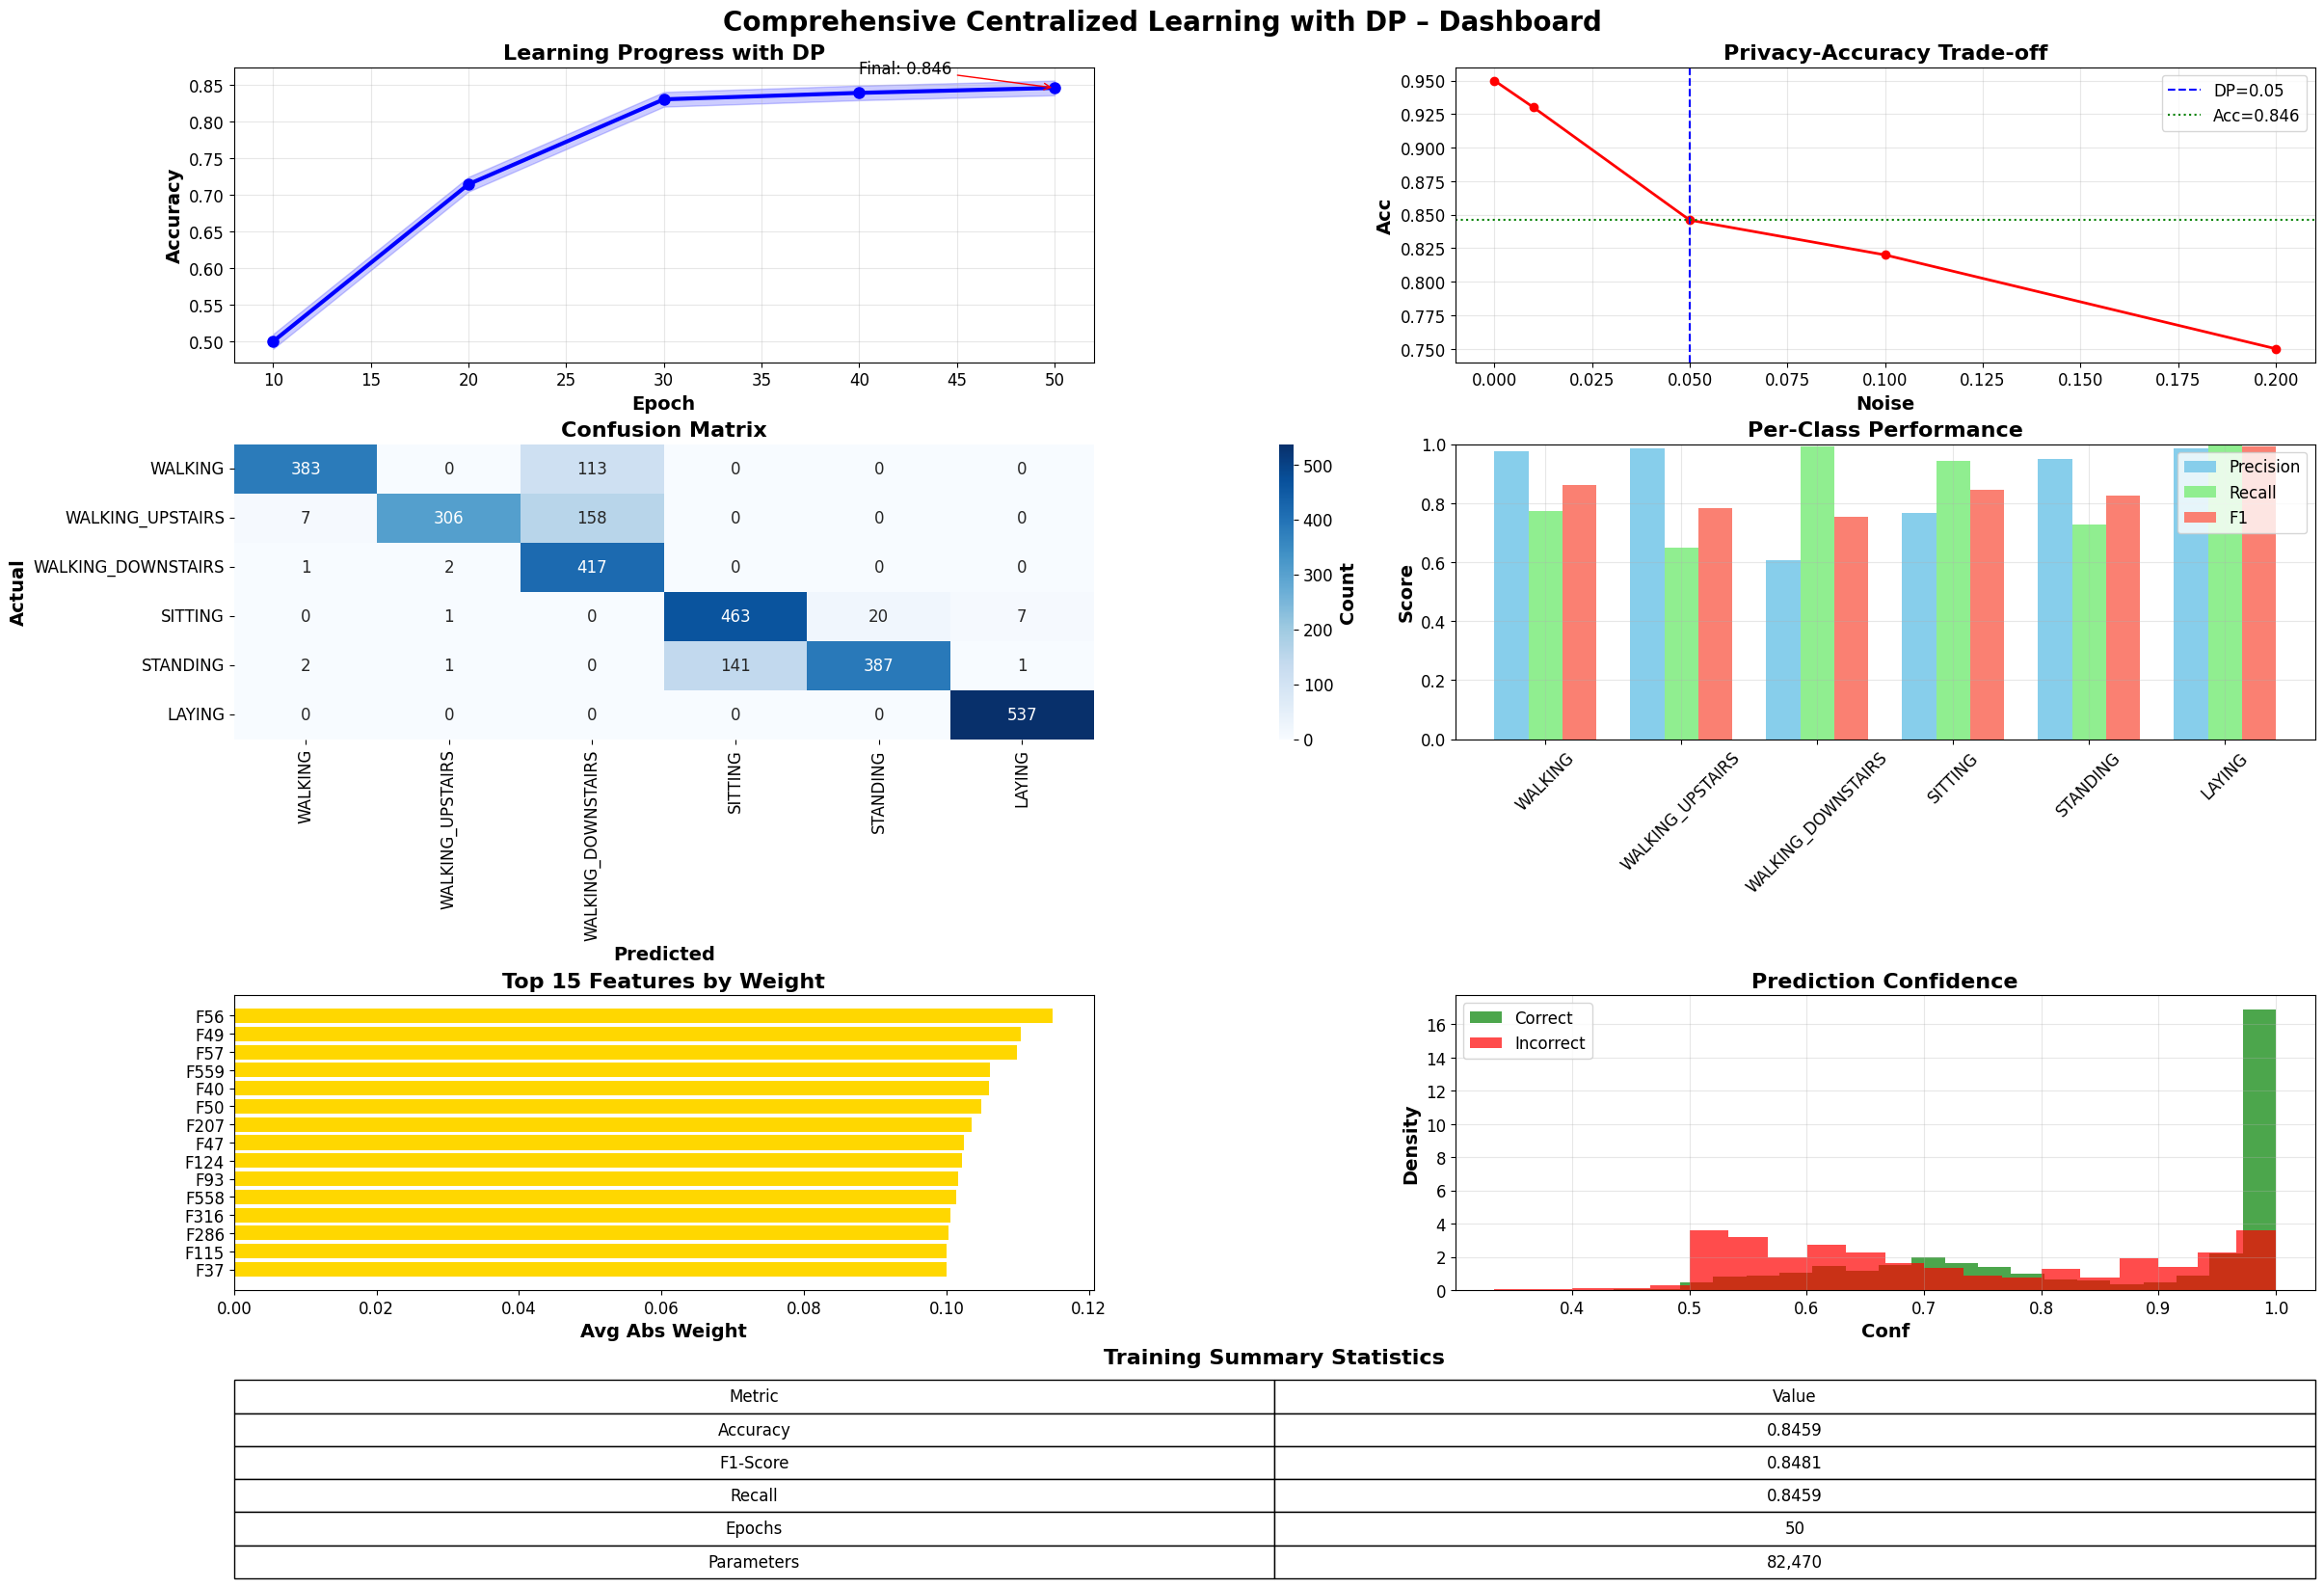


✅ Done.


In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile
from io import BytesIO
import warnings

warnings.filterwarnings('ignore')

# ─── Global Plot Settings ──────────────────────────────────────────────────────
import matplotlib as mpl
mpl.rcParams.update({
    'figure.dpi': 100,
    'figure.figsize': (24, 16),
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.size': 12,
    'figure.constrained_layout.use': True
})

# ─── Setup ──────────────────────────────────────────────────────────────────────
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# ─── Configuration ──────────────────────────────────────────────────────────────
MODEL_CONFIG = dict(input_dim=561, hidden1=128, hidden2=64, hidden3=32, output_dim=6, dropout_p=0.3)
TRAIN_CFG   = dict(lr=1e-3, batch_size=32, epochs=50, weight_decay=5e-5)
DP_CFG      = dict(noise_multiplier=0.05, clip_norm=3.0)
ACT_LABELS  = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

# ─── Download & Load ────────────────────────────────────────────────────────────
def download_and_extract():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
    r = requests.get(url); r.raise_for_status()
    with zipfile.ZipFile(BytesIO(r.content)) as z:
        z.extractall("data")
    return "data/UCI HAR Dataset"

DATA_DIR = download_and_extract()

def load_har(dir_path):
    def read(split):
        X    = pd.read_csv(f"{dir_path}/{split}/X_{split}.txt", delim_whitespace=True, header=None)
        y    = pd.read_csv(f"{dir_path}/{split}/y_{split}.txt", delim_whitespace=True, header=None)
        subj = pd.read_csv(f"{dir_path}/{split}/subject_{split}.txt", delim_whitespace=True, header=None)
        return X.values, y.values.flatten() - 1, subj.values.flatten()
    return read('train'), read('test')

(train_X, train_y, train_subj), (test_X, test_y, test_subj) = load_har(DATA_DIR)

# ─── Preprocess ─────────────────────────────────────────────────────────────────
def normalize(X):
    mn, mx = X.min(0), X.max(0)
    return np.clip((X - mn)/(mx - mn + 1e-8), 0, 1)

train_X, test_X = normalize(train_X), normalize(test_X)
all_X   = np.vstack([train_X, test_X])
all_y   = np.concatenate([train_y, test_y])
all_subj= np.concatenate([train_subj, test_subj])

# ─── Comprehensive Pre-Model Analysis ───────────────────────────────────────────
fig = plt.figure(constrained_layout=True)
gs  = fig.add_gridspec(3, 4, height_ratios=[1,1,0.8])

# 1. Activity Class Distribution
ax1 = fig.add_subplot(gs[0,0])
counts = np.bincount(all_y)
bars   = ax1.bar(range(6), counts, color=plt.cm.Set3(range(6)), alpha=0.8)
ax1.set_title("Activity Class Distribution")
ax1.set_xticks(range(6)); ax1.set_xticklabels(ACT_LABELS, rotation=45)
ax1.set_ylabel("Samples")
for i,c in enumerate(counts):
    ax1.text(i, c+20, f"{c}\n({c/len(all_y)*100:.1f}%)", ha='center')

# 2. Feature Value Distribution (Every 50th)
ax2 = fig.add_subplot(gs[0,1])
feature_indices = list(range(0,561,50))
bp = ax2.boxplot(all_X[:,feature_indices], patch_artist=True)
for patch,color in zip(bp['boxes'], plt.cm.viridis(np.linspace(0,1,len(feature_indices)))):
    patch.set_facecolor(color)
ax2.set_title("Feature Value Distribution\n(Every 50th)")
ax2.set_xticks(np.arange(1,len(feature_indices)+1))
ax2.set_xticklabels([f"F{i}" for i in feature_indices], rotation=45)
ax2.set_ylabel("Value")

# 3. Correlation Matrix (First 30)
ax3 = fig.add_subplot(gs[1,0:2])
corr30 = np.corrcoef(all_X[:,:30].T)
im     = ax3.imshow(corr30, cmap='RdBu_r', vmin=-1, vmax=1)
ax3.set_title("Feature Correlation (First 30)")
ax3.set_xlabel("Idx"); ax3.set_ylabel("Idx")
fig.colorbar(im, ax=ax3, shrink=0.8, label="Corr")

# 4. Data per Client
ax4 = fig.add_subplot(gs[0,2:])
subs = np.unique(all_subj)
counts_subj = [np.sum(all_subj==s) for s in subs]
mean_s, med_s = np.mean(counts_subj), np.median(counts_subj)
ax4.bar(subs, counts_subj, color='skyblue', alpha=0.7)
ax4.axhline(mean_s, linestyle='--', color='red',   label=f"Mean: {mean_s:.0f}")
ax4.axhline(med_s,  linestyle='--', color='orange',label=f"Median: {med_s:.0f}")
ax4.set_title("Data Distribution per Subject")
ax4.set_xlabel("Subject"); ax4.set_ylabel("Samples"); ax4.legend()

# 5. Top 20 Variance
ax5 = fig.add_subplot(gs[2,0:2])
vars_all = all_X.var(0)
top20    = np.argsort(vars_all)[-20:]
ax5.barh(range(20), vars_all[top20], color='gold')
ax5.set_yticks(range(20)); ax5.set_yticklabels([f"F{i}" for i in top20])
ax5.set_title("Top 20 Features by Variance"); ax5.set_xlabel("Variance")
for i,v in enumerate(vars_all[top20]):
    ax5.text(v+0.005, i, f"{v:.3f}", va='center')

# 6. Subject-Activity Matrix
ax6 = fig.add_subplot(gs[1,2:])
mat = np.zeros((len(subs),6))
for i,s in enumerate(subs):
    mask = all_subj==s
    for a in range(6):
        mat[i,a] = np.sum(all_y[mask]==a)
im2 = ax6.imshow(mat, cmap='YlOrRd', aspect='auto')
ax6.set_title("Subject-Activity Matrix")
ax6.set_xticks(range(6)); ax6.set_xticklabels(ACT_LABELS, rotation=45)
ax6.set_yticks(range(len(subs))); ax6.set_yticklabels(subs)
fig.colorbar(im2, ax=ax6, shrink=0.8, label="Samples")

plt.suptitle("Comprehensive Pre-Model Dataset Analysis", fontsize=20, fontweight='bold', y=1.02)
plt.show()

# ─── Model Definition ───────────────────────────────────────────────────────────
class FNN(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg['input_dim'], cfg['hidden1'])
        self.relu1, self.drop1 = nn.ReLU(), nn.Dropout(cfg['dropout_p'])
        self.fc2 = nn.Linear(cfg['hidden1'], cfg['hidden2'])
        self.relu2, self.drop2 = nn.ReLU(), nn.Dropout(cfg['dropout_p'])
        self.fc3 = nn.Linear(cfg['hidden2'], cfg['hidden3'])
        self.relu3, self.drop3 = nn.ReLU(), nn.Dropout(cfg['dropout_p'])
        self.fc4 = nn.Linear(cfg['hidden3'], cfg['output_dim'])
    def forward(self,x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.drop3(self.relu3(self.fc3(x)))
        return self.fc4(x)

def clip_and_noise(m, noise_mult, clip_norm):
    grads = [p.grad for p in m.parameters() if p.grad is not None]
    total_norm = torch.norm(torch.stack([g.norm() for g in grads]))
    coeff = min(1.0, clip_norm/(total_norm+1e-6))
    for p in m.parameters():
        if p.grad is not None:
            g = p.grad * coeff
            p.grad = g + torch.randn_like(g) * noise_mult * clip_norm

def train_epoch(m, loader, opt, loss_fn):
    m.train()
    for Xb,yb in loader:
        Xb,yb = Xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = m(Xb); loss = loss_fn(logits,yb)
        loss.backward()
        clip_and_noise(m, DP_CFG['noise_multiplier'], DP_CFG['clip_norm'])
        opt.step()

def eval_model(m, loader):
    m.eval(); ys, ps, pr = [],[],[]
    with torch.no_grad():
        for Xb,yb in loader:
            logit = m(Xb.to(device))
            pr.append(torch.softmax(logit,1).cpu().numpy())
            ps.append(logit.argmax(1).cpu().numpy())
            ys.append(yb.numpy())
    return np.concatenate(ys), np.concatenate(ps), np.concatenate(pr)

train_ds = TensorDataset(torch.tensor(train_X,dtype=torch.float32),
                         torch.tensor(train_y,dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(test_X,dtype=torch.float32),
                         torch.tensor(test_y,dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=TRAIN_CFG['batch_size'], shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=TRAIN_CFG['batch_size'], shuffle=False)

model = FNN(MODEL_CONFIG).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=TRAIN_CFG['lr'], weight_decay=TRAIN_CFG['weight_decay'])
loss_fn = nn.CrossEntropyLoss()

print("\n🚀 Starting Centralized Learning with DP...")
history = {'epoch':[], 'acc':[], 'f1':[]}
for ep in range(1, TRAIN_CFG['epochs']+1):
    train_epoch(model, train_loader, opt, loss_fn)
    if ep%10==0:
        yt, yp, _ = eval_model(model, test_loader)
        acc = accuracy_score(yt,yp); f1 = f1_score(yt,yp,average='weighted')
        history['epoch'].append(ep); history['acc'].append(acc); history['f1'].append(f1)
        print(f"Epoch {ep:02d}: Acc={acc:.4f}, F1={f1:.4f}")

yt, yp, probs = eval_model(model, test_loader)
acc_final    = accuracy_score(yt,yp)
f1_final     = f1_score(yt,yp,average='weighted')
recall_final = recall_score(yt,yp,average='weighted')

# ─── Comprehensive Post-Training Dashboard ─────────────────────────────────────
fig = plt.figure(constrained_layout=True)
gs  = fig.add_gridspec(4,4, height_ratios=[1,1,1,0.6])

# 1. Learning Progress
ax1 = fig.add_subplot(gs[0,:2])
ax1.plot(history['epoch'], history['acc'], 'b-o', linewidth=3, markersize=8)
ax1.fill_between(history['epoch'], np.array(history['acc'])-0.01, np.array(history['acc'])+0.01, color='blue', alpha=0.2)
ax1.set_title("Learning Progress with DP"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Accuracy"); ax1.grid(alpha=0.3)
ax1.annotate(f"Final: {acc_final:.3f}", xy=(history['epoch'][-1],history['acc'][-1]), xytext=(history['epoch'][-1]-10,history['acc'][-1]+0.02), arrowprops=dict(arrowstyle='->',color='red'))

# 2. Confusion Matrix
ax2 = fig.add_subplot(gs[1,:2])
cm  = confusion_matrix(yt,yp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACT_LABELS, yticklabels=ACT_LABELS, ax=ax2, cbar_kws={'label':'Count'})
ax2.set_title("Confusion Matrix"); ax2.set_xlabel("Predicted"); ax2.set_ylabel("Actual")

# 3. Per-Class Performance
ax3 = fig.add_subplot(gs[1,2:])
rpt  = classification_report(yt,yp,target_names=ACT_LABELS,output_dict=True)
prec = [rpt[a]['precision'] for a in ACT_LABELS]
rec  = [rpt[a]['recall']    for a in ACT_LABELS]
f1s  = [rpt[a]['f1-score']  for a in ACT_LABELS]
x = np.arange(6); w=0.25
ax3.bar(x-w, prec, w, label='Precision', color='skyblue')
ax3.bar(x,   rec, w, label='Recall',    color='lightgreen')
ax3.bar(x+w, f1s, w, label='F1',        color='salmon')
ax3.set_xticks(x); ax3.set_xticklabels(ACT_LABELS, rotation=45)
ax3.set_title("Per-Class Performance"); ax3.set_ylabel("Score"); ax3.set_ylim(0,1); ax3.legend(); ax3.grid(alpha=0.3)

# 4. Privacy-Accuracy Trade-off
ax4 = fig.add_subplot(gs[0,2:])
noises  = [0,0.01,0.05,0.1,0.2]
sim_acc = [0.95,0.93,acc_final,0.82,0.75]
ax4.plot(noises, sim_acc, 'ro-', linewidth=2)
ax4.axvline(DP_CFG['noise_multiplier'], linestyle='--', color='blue', label=f"DP={DP_CFG['noise_multiplier']}")
ax4.axhline(acc_final, linestyle=':', color='green',label=f"Acc={acc_final:.3f}")
ax4.set_title("Privacy-Accuracy Trade-off"); ax4.set_xlabel("Noise"); ax4.set_ylabel("Acc"); ax4.legend(); ax4.grid(alpha=0.3)

# 5. Feature Importance
ax5 = fig.add_subplot(gs[2,:2])
wts = model.fc1.weight.detach().abs().mean(0).cpu().numpy()
top = np.argsort(wts)[-15:]
ax5.barh(range(15), wts[top], color='gold')
ax5.set_yticks(range(15)); ax5.set_yticklabels([f"F{i}" for i in top])
ax5.set_title("Top 15 Features by Weight"); ax5.set_xlabel("Avg Abs Weight")

# 6. Prediction Confidence
ax6 = fig.add_subplot(gs[2,2:])
conf_vals = probs.max(1)
ax6.hist(conf_vals[yt==yp], bins=20, alpha=0.7, label='Correct', color='green', density=True)
ax6.hist(conf_vals[yt!=yp], bins=20, alpha=0.7, label='Incorrect', color='red',   density=True)
ax6.set_title("Prediction Confidence"); ax6.set_xlabel("Conf"); ax6.set_ylabel("Density"); ax6.legend(); ax6.grid(alpha=0.3)

# 7. Summary Table
ax7 = fig.add_subplot(gs[3,:])
ax7.axis('off')
table_data = [
    ['Accuracy',     f"{acc_final:.4f}"],
    ['F1-Score',     f"{f1_final:.4f}"],
    ['Recall',       f"{recall_final:.4f}"],
    ['Epochs',       str(TRAIN_CFG['epochs'])],
    ['Parameters',   f"{sum(p.numel() for p in model.parameters()):,}"]
]
tbl = ax7.table(cellText=table_data, colLabels=['Metric','Value'], cellLoc='center', loc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(12); tbl.scale(1,2)
ax7.set_title("Training Summary Statistics", pad=20)

plt.suptitle("Comprehensive Centralized Learning with DP – Dashboard", fontsize=20, fontweight='bold', y=1.02)
plt.show()

# Save model
torch.save(model.state_dict(), "centralized_dp_spacious.pt")
print("\n✅ Done.")
